In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern

### Transformations from Original to Natural Parameters (and vice-versa)

In [2]:
def eta(Theta):
    """
    Theta = (theta_1, theta_2, ..., theta_d, sigma2)
    """
    return np.append(Theta[:-1]/Theta[-1], -1 / (2 * Theta[-1]) )

def eta_inv(Eta):
    return np.append( - Eta[:-1] / (2 * Eta[-1]), -1 / (2 * Eta[-1]) )

def eta_inv_jac(Eta):
    n = Eta.size

    return np.block( [
        [ np.diag(np.repeat( -1 / (2 * Eta[-1]), n-1 )), (Eta[:-1] / (2 * Eta[-1]**2)).reshape(-1, 1) ],
        [ np.zeros((1, n-1)),                           np.array([[ 1 / (2 * Eta[-1]**2) ]]) ]
               ]
            )

def eta_jac(Theta):
    n = Theta.size
    return np.block( [
        [ np.diag(np.repeat( 1 / (Theta[-1]), n-1 )), ( - Theta[:-1] / Theta[-1]**2 ).reshape(-1, 1) ],
        [ np.zeros((1, n-1)),                           np.array([[ 1 / (2 * Theta[-1]**2) ]]) ]
               ]
            )

In [3]:
test_eta = np.array([0.1, 0.4, 0.2, 0.9])
print(eta_inv(eta(test_eta)))

eta_inv_jac(test_eta)

eta_jac(eta(test_eta))

[0.1 0.4 0.2 0.9]


array([[-1.8 ,  0.  ,  0.  , -0.36],
       [ 0.  , -1.8 ,  0.  , -1.44],
       [ 0.  ,  0.  , -1.8 , -0.72],
       [ 0.  ,  0.  ,  0.  ,  1.62]])

### Setting up the data

(0.0, 4.0)

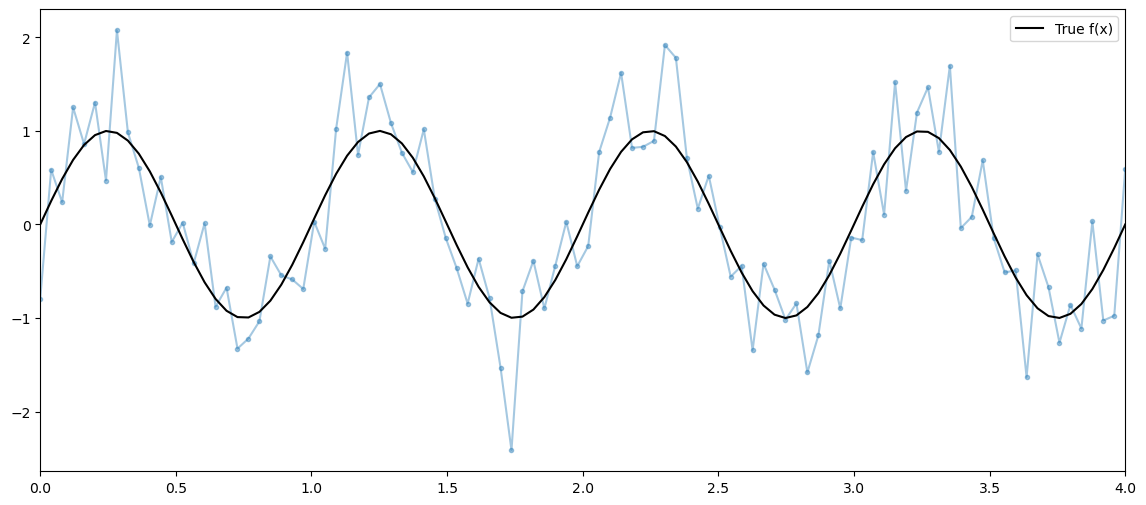

In [230]:
#Setting up the data
xmin = 0 
xmax = 4
d = 100
grid = np.linspace(xmin, xmax, d)

num_samples = 1 #number of samples per x_i 
num_params = d + 1 # one mean parameter per x_i, and sigma2 (share by all x_i's)

true_sigma2 = 0.5**2
true_theta = np.append(np.zeros((d,)), true_sigma2)
f = lambda x : np.sin(2 * np.pi * x)
data = (f(grid) + np.random.normal(loc=true_theta[:-1], scale=np.sqrt(true_theta[-1]), size=(num_samples, d))).T

plt.figure(figsize=(14,6))
plt.plot(grid, data, '.-', alpha=0.4)
plt.plot(grid, f(grid), color='black', label="True f(x)")
plt.legend()
plt.xlim(xmin, xmax)

### Setting up priors

In [231]:
#Setting up the prior covariance (GP kernel) and the prior mean on theta = (theta1, ..., thetaT, sigma2)
length_scale= 0.5
nu = 5/2
magnitude = 2.
large_number = 10**8 #this is a trick so that we automatically get k(t_sig^2, t_sig^2) = 1 and k(t_x_i, t_sig^2) = 0
kernel = magnitude * Matern(length_scale=length_scale, nu=nu)

prior_sigma2 = 0.5
theta_prior_mean = np.append(np.zeros((d,)), prior_sigma2)
theta_prior_cov = kernel(np.append(grid, large_number).reshape(-1,1)) 
theta_prior_cov[-1,-1] *= (1/magnitude) * 0.5

#converting the prior on theta to natural parameters
eta_prior_mean = eta(theta_prior_mean)
eta_prior_cov = eta_jac(theta_prior_mean) @ theta_prior_cov @ eta_jac(theta_prior_mean).T


### Compute $\Lambda_n$ and $\nu_n$ and the posterior mean on $\bm{\eta}$, and convert back to original parameters

In [232]:
#Computing Lambda_n and Nu_n
Lambda_n = np.block([[np.eye(d), 2 * data.mean(axis=1).reshape(-1,1)],
           [2 * data.mean(axis=1).reshape(1,-1), (4/num_samples) * sum(data[:, j] @ data[:, j].T for j in range(num_samples))]])

Nu_n = 2 * np.append(np.zeros((d,)), 2 * d)

#Compute Posterior mean and variance
eta_post_cov = np.linalg.inv(np.linalg.inv(eta_prior_cov) + 2 * num_samples * Lambda_n)
eta_post_mean = eta_post_cov @ (np.linalg.inv(eta_prior_cov) @ eta_prior_mean - num_samples * Nu_n)

#converting back from eta to mu, sigma2, and obtaining the mean and covariance for mu and sigma2
theta_post_mean = eta_inv(eta_post_mean)
theta_post_cov = eta_inv_jac(eta_post_mean) @ eta_post_cov @ eta_inv_jac(eta_post_mean).T

### Plot results

sigma2 :  0.23094355366242783 0.023528473888911595
true sigma2 :  0.25


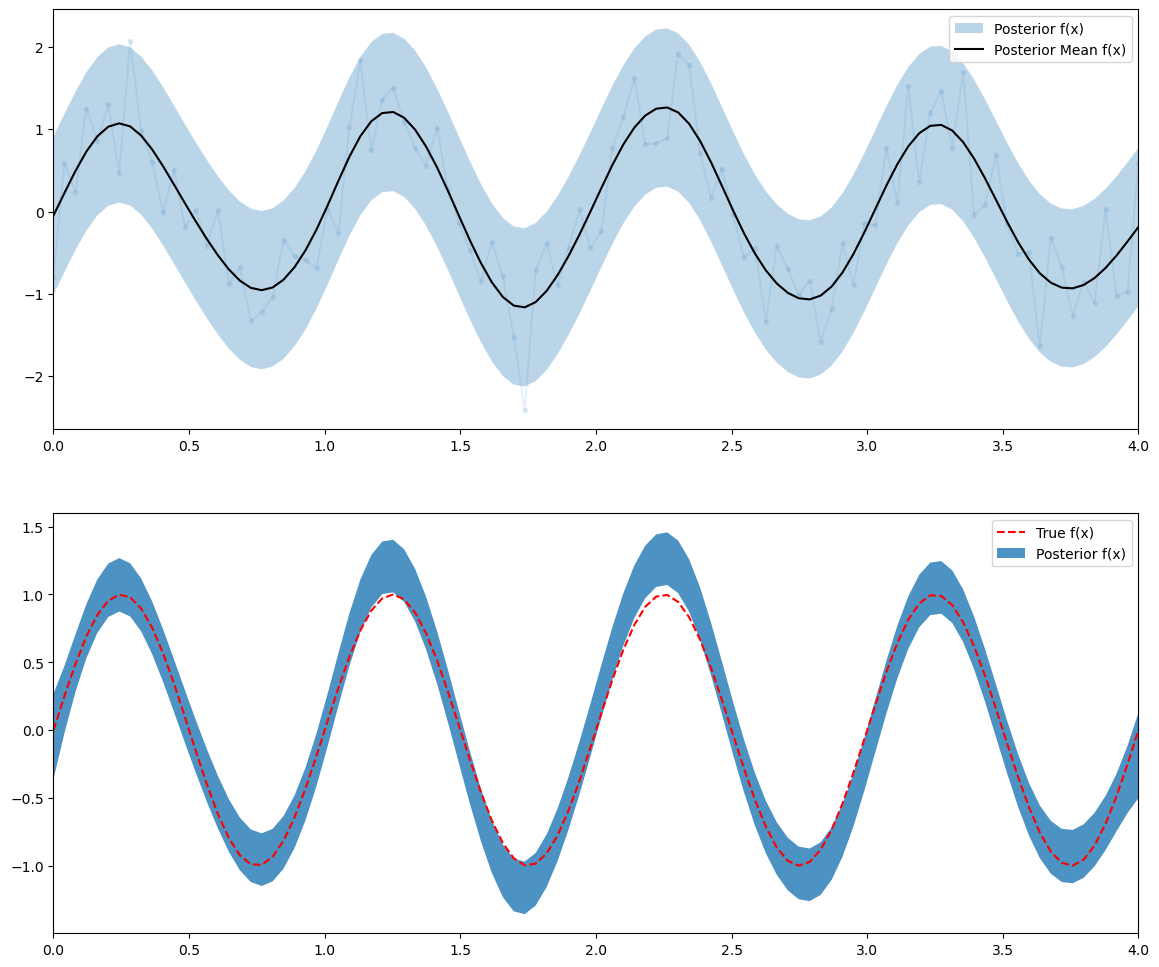

In [233]:
err_estimate = 3 * np.sqrt(np.diag(theta_post_cov)[:-1])
sigma2_err_estimate = 3 * np.sqrt(theta_post_cov[-1, -1])

#plotting results
fig, axs = plt.subplots(2,1, figsize=(14,12))

axs[0].plot(grid, data, '.-', alpha=0.1)
axs[0].fill_between(grid, theta_post_mean[:-1] - 2*np.sqrt(theta_post_mean[-1]), theta_post_mean[:-1] + 2*np.sqrt(theta_post_mean[-1]), alpha=0.3, label="Posterior f(x)")
axs[0].plot(grid, theta_post_mean[:-1], color='black', label="Posterior Mean f(x)")
axs[0].legend()
axs[0].set_xlim(xmin, xmax)

axs[1].plot(grid, f(grid), "--", color='red', label="True f(x)")
axs[1].fill_between(grid, theta_post_mean[:-1] - err_estimate, theta_post_mean[:-1] + err_estimate, alpha=0.8, label="Posterior f(x)")
axs[1].legend()
axs[1].set_xlim(xmin, xmax)

print("sigma2 : ", theta_post_mean[-1], sigma2_err_estimate)
print("true sigma2 : ", true_sigma2)